# HNCDI Explain: Mathematical Fundamentals of Quantum Computing

### Install the qiskit library in the colab environment

Please run the below cell to ensure the notebook has qiskit installed.

In [26]:
# Install the qiskit library
%pip install 'qiskit[visualization]'
%pip install qiskit-ibm-runtime
%pip install qiskit-aer


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Tutorial 2: Estimate $\pi$ using quantum algorithms

In [27]:
import numpy as np
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as real_sampler
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
# from qiskit import assemble
import matplotlib.pyplot as plt

In [ ]:
my_token = "<Enter your IBM quantum token here>"

service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)

/var/folders/7p/yp3_4bhx1hb234hbhxty04tr0000gn/T/ipykernel_53036/1134007162.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum", token=my_token)


In [29]:
# Set simulator backend
sampler = AerSimulator()

## Approximating $\pi$ 

In [30]:
#Compute the Inverse Quantum Fourier Transform

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

In [31]:
#Initial state of Quantum Phase Estimation

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

In [32]:
def run_job(circ, backend, shots, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level, coupling_map=None)
    # qobj = assemble(t_circ, shots=shots)
    job = backend.run(t_circ)
    result = job.result()
    return result

In [33]:
def get_pi_estimate(n_qubits, backend, shots):
        
    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    
    # create the input state
    qpe_pre(circ, n_qubits)
        
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))
    
    # optionally save to a file
    if n_qubits == 3:
        circ.draw(filename='qpe')

    # run the job and get the results
    job_results = run_job(circ, backend, shots, optimization_level=0)
    
    # Extract the counts from the result
    if(type(backend) is SamplerV2):
        result = job_results[0].data.c
        counts = result.get_counts()
    else:
        counts = job_results.get_counts()
        
    print('counts = ', counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    print('max_counts_result = ', max_counts_result)
    max_counts_result = int(max_counts_result, 2)
    print('max_counts_result = ', max_counts_result)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

In [34]:
# estimate pi using different numbers of qubits

number_of_shots = 1024
upper_limit_qubits = 13 # Add an upper limit of qubits
nqs = list(range(2,upper_limit_qubits+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq, sampler, number_of_shots)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

counts =  {'11': 55, '10': 63, '00': 228, '01': 678}
max_counts_result =  01
max_counts_result =  1
2 qubits, pi ≈ 2.0
counts =  {'011': 18, '111': 16, '100': 11, '110': 7, '001': 791, '101': 7, '000': 39, '010': 135}
max_counts_result =  001
max_counts_result =  1
3 qubits, pi ≈ 4.0
counts =  {'1110': 5, '1010': 3, '1001': 6, '1011': 7, '0101': 16, '0110': 8, '0011': 492, '0001': 49, '1100': 3, '0100': 54, '1000': 7, '0000': 20, '0010': 336, '0111': 3, '1101': 3, '1111': 12}
max_counts_result =  0011
max_counts_result =  3
4 qubits, pi ≈ 2.6666666666666665
counts =  {'11000': 1, '01001': 1, '01011': 1, '01000': 1, '00001': 1, '00011': 4, '00111': 2, '01111': 1, '00110': 9, '00100': 4, '00010': 1, '10000': 1, '00101': 997}
max_counts_result =  00101
max_counts_result =  5
5 qubits, pi ≈ 3.2
counts =  {'010000': 1, '001110': 1, '000110': 2, '111011': 1, '111101': 2, '101110': 1, '000001': 2, '111111': 1, '001111': 2, '001101': 2, '001000': 7, '001100': 9, '000111': 5, '100001': 1, '0001

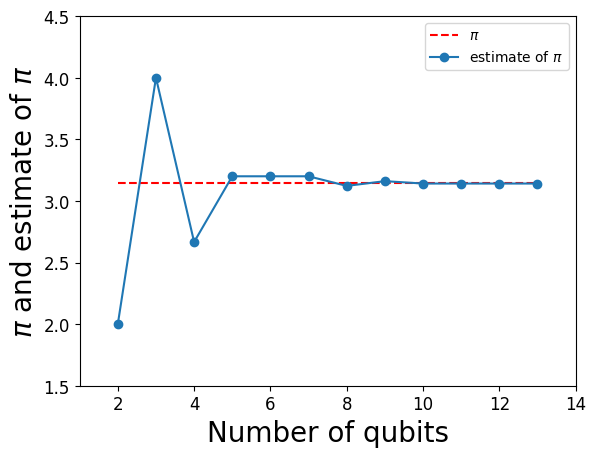

In [35]:
pi = np.pi

plt.plot(nqs, [pi]*len(nqs), '--r')
plt.plot(nqs, pi_estimates, '.-', markersize=12)
plt.xlim([nqs[0]-1,nqs[-1]+1])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':20})
plt.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()